In [1]:
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
np.seterr(all='ignore')
from threeML import *


Did you try to import pygsl in the build directory?

Well, that does not work out of the box. If you want to do that, please
use
      python setup.py build_ext -i
to add the necessary extension module in the local pygsl/ directory!

Please read the README first! Any further questions or missing information
please post to pygsl-discuss@lists.sourceforge.net!

Configuration read from /Users/jburgess/.threeML/threeML_config.yml



WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176


WARNING RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility


WARNING RuntimeWarning: numpy.ufunc size changed, may indicate binary incom

In [2]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')


#The .pha, .bak and .rsp files have been prepared with the Fermi
#official software. In the future it will be possible to create
#them directly from the plugin

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )

#Now repeat for the other GBM detectors

obsSpectrum = os.path.join( datadir, "bn090217206_n9_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n9_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n9_weightedrsp.rsp{1}" )
#Plugin instance
NaI9 = OGIPLike( "NaI9", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use
NaI9.set_active_measurements( "10.0-30.0", "40.0-950.0" )


obsSpectrum = os.path.join( datadir, "bn090217206_b1_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_b1_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_b1_weightedrsp.rsp{1}" )
#Plugin instance
BGO1 = OGIPLike( "BGO1", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use (in this case, from 200 keV to 10 MeV)
BGO1.set_active_measurements( "200-10000" )


data_list = DataList( NaI6, NaI9, BGO1 )

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 4-20
Range 40.0-950.0 translates to channels 26-125
Now using 117 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 6-21
Range 40.0-950.0 translates to channels 27-125
Now using 115 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 200-10000 translates to channels 2-89
Now using 88 channels out of 128


In [3]:
#Let's use a Band model, a phenomenological model typically used for GRBs
bb = Blackbody()

pl  = Powerlaw()

comp_model = bb+pl


pl_co = Powerlaw() *Exponential_cutoff()




In [4]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=comp_model )

model = Model( GRB )

jl = JointLikelihood( model, data_list )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn090217206.spectrum.main.composite.K_1,(1.61 +/- 0.18)e-06,1 / (cm2 keV3 s)
1,bn090217206.spectrum.main.composite.kT_1,79.4 +/- 2.8,keV
2,bn090217206.spectrum.main.composite.K_2,6.3 +/- 0.5,1 / (cm2 keV s)
3,bn090217206.spectrum.main.composite.index_2,-1.489 +/- 0.017,



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,-0.95,-0.41,0.28
-0.95,1.00,0.50,-0.46
-0.41,0.50,1.00,-0.92
0.28,-0.46,-0.92,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,2245.891237
NaI6,854.586645
NaI9,767.383856
BGO1,623.920736


<IPython.core.display.Javascript object>


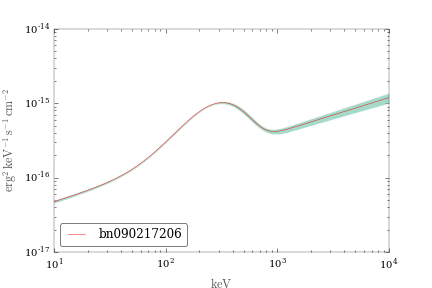

In [9]:
spec_plot_mle = SpectralPlotter(jl)
_=spec_plot_mle.plot_model(x_unit='keV',
                         y_unit='erg2/(cm2 keV s)',
                         ene_min=10,
                         ene_max=1e4,
                         loc='lower left',
                         lw=.5,
                         ls='-')

<IPython.core.display.Javascript object>


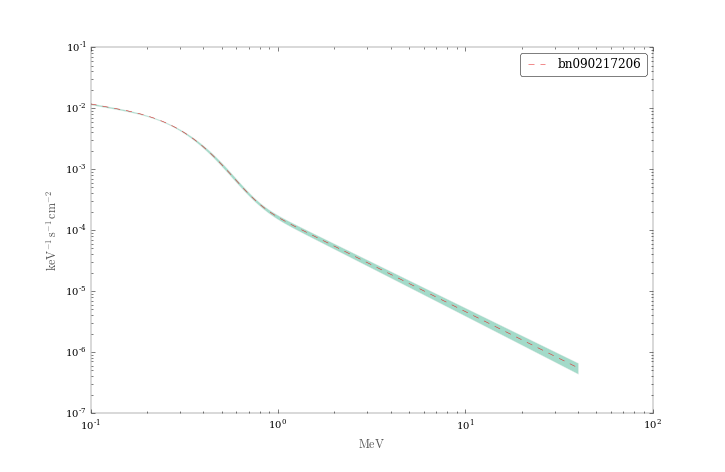

In [7]:

_=spec_plot_mle.plot_model(x_unit='MeV',
                         y_unit='1/(cm2 keV s)',
                         ene_min=1.E-1,
                         ene_max=4E1,
                         loc='upper right',
                         lw=.5,
                         ls='--')

In [18]:
fit_cmap = plt.cm.jet
contour_cmap = plt.cm.Set3

_=spec_plot_mle.plot_components(x_unit='keV',
                         y_unit='erg2/(cm2 keV s)',
                         ene_min=1E19,
                         ene_max=1E25,
                         loc='lower left',
                         lw=.5,
                         ls='-',
                         fit_cmap=fit_cmap,
                         contour_cmap=contour_cmap,
                         contour_alpha=.6  )

NameError: name 'spec_plot_mle' is not defined

In [9]:
comp_model.K_1.prior = Log_uniform_prior(lower_bound = 1E-7, upper_bound = 1E-5)
comp_model.K_2.prior = Log_uniform_prior(lower_bound =1E-1,upper_bound = 1E2)
comp_model.index_2.set_uninformative_prior(Uniform_prior)
comp_model.kT_1.prior = Log_uniform_prior(lower_bound =1E1,upper_bound = 1E4)

bayes = BayesianAnalysis(model, data_list)

res= bayes.sample(100,100,1000)


Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.58443


In [10]:
bayes_plot = SpectralPlotter(bayes)

<IPython.core.display.Javascript object>


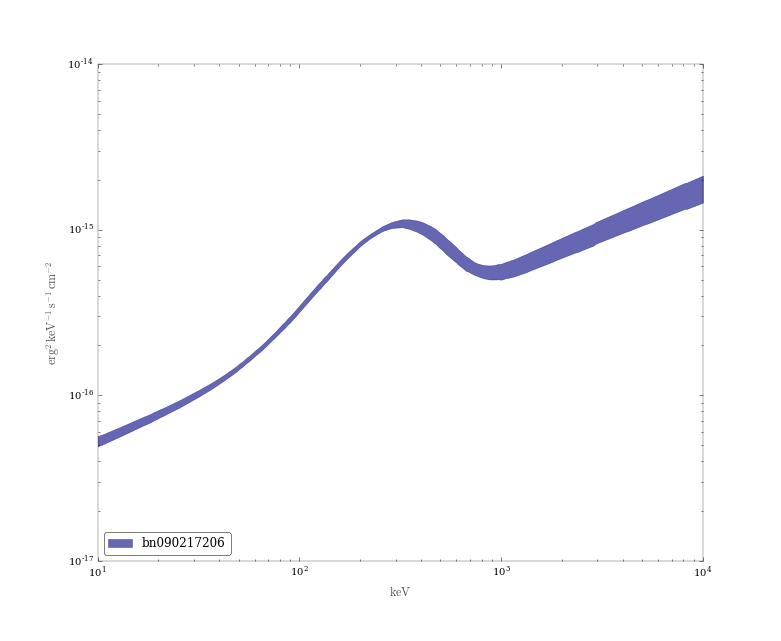

In [11]:
_=bayes_plot.plot_model(x_unit='keV',
                         y_unit='erg2/(cm2 keV s)',
                         ene_min=10,
                         ene_max=1E4,
                         loc='lower left',
                         lw=.5,
                         ls='-',
                         fit_cmap=fit_cmap,
                         contour_cmap=contour_cmap,
                         contour_alpha=.6)

<IPython.core.display.Javascript object>


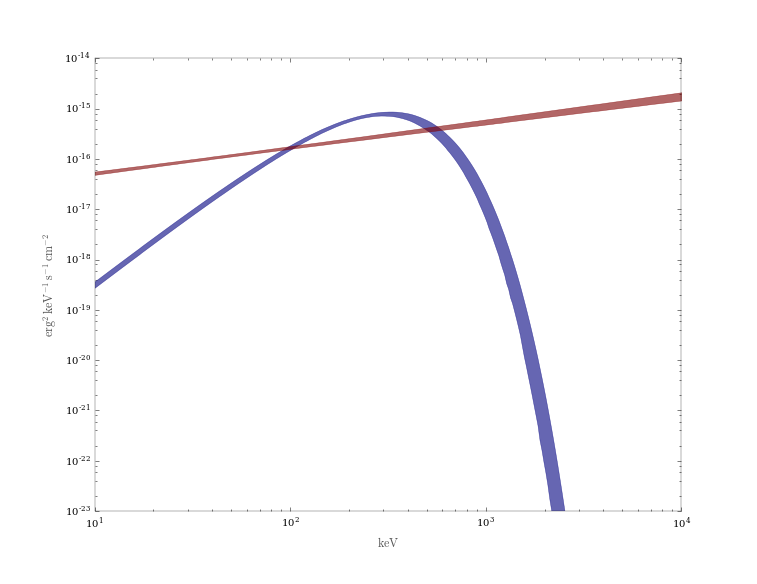

(1e-23, 1e-14)

In [13]:
_=bayes_plot.plot_components(x_unit='keV',
                           y_unit='erg2/(cm2 keV s)',
                           ene_min=10,
                           ene_max=1E4,
                           lw=.5,
                           ls='-',
                           fit_cmap=fit_cmap,
                           contour_alpha=.6,
                           legend=False,
                           thin=10)
plt.ylim(1E-23)

<IPython.core.display.Javascript object>


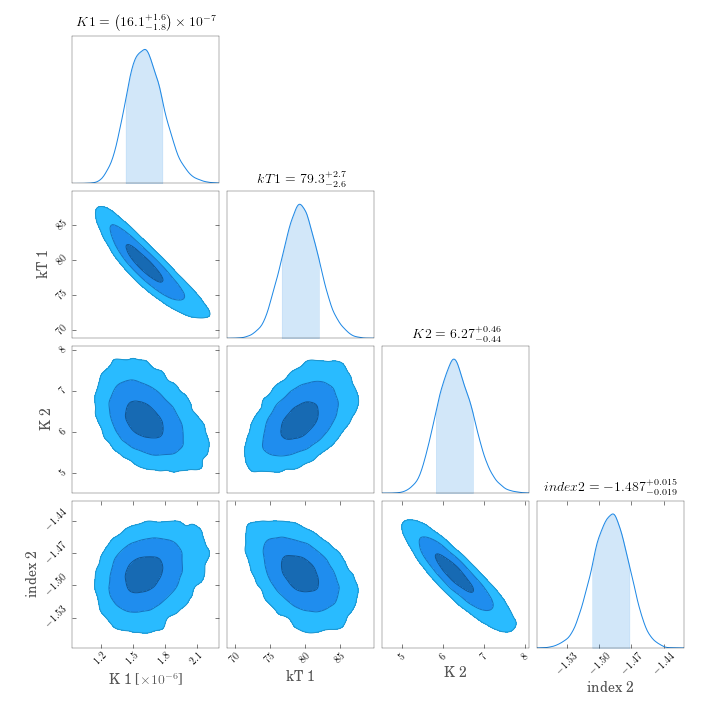

INFO:chainconsumer.chain:Plotting surfaces with [20] bins


In [15]:
_=bayes.corner_plot_cc()

In [6]:
f = 1e19 * u.Hz

In [7]:
from astropy.constants import h

In [20]:
a=f*h

In [22]:
b=a/ (1*u.keV)

In [23]:
b.decompose()

<Quantity 41.356675130246956>

In [30]:
(a.cgs /h).to('Hz')

<Quantity 1.0000000000000002e+19 Hz>

In [31]:
a.cgs

<Quantity 6.62606957e-08 erg>

In [8]:
(u.Hz).to('keV')

UnitConversionError: 'Hz' (frequency) and 'keV' (energy) are not convertible